# Benchmarking SQL vs Python

The work we have done so far is interesting but largely academic. The question remains as to why we may want to do these kinds of matrix calculations inside of SQL instead of loading the matrices into Python and using the mature libraries (such as NumPy) that exist for exactly such calculations. In this notebook, we investigate the relative speed of both methods for large random matrices. We also investigate how our results may be affected by slow internet speeds by using simulated delay. 

## Initial Setup

### Variables

In [34]:
INTERNET_SPEED = 10 # The simulated internet speed in Mbps
DIGIT_BITS = 64
DELAY =  False

In [35]:
SPARSE_PROP = 0.1

### Load SQL

In [36]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text

In [37]:
load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL")
engine = create_engine(DATABASE_URL)

#### Quick test

In [38]:
with engine.connect() as con:
    result = con.execute(text("SELECT * FROM A")).fetchall()

    for matrix in result:
        print(matrix)

(1, 1, 1.0)
(1, 2, 2.0)
(1, 3, 0.0)
(2, 1, 1.0)
(2, 2, 1.0)
(2, 3, 4.0)
(3, 1, 0.0)
(3, 2, 7.0)
(3, 3, 1.0)


### Generate Matrices

In [39]:
import numpy as np

In [40]:
def put_mat(n:int, m:int, name:str, mat):
    sql = f"""INSERT INTO {name} (i, j, value) VALUES"""
    for i in range(n):
        for j in range(m):
            if i==1 and j==1:
                sql += f"({i+1}, {j+1}, {mat[i][j]}),"
            else:
                sql += f"\n({i+1}, {j+1}, {mat[i][j]}),"
    sql= sql[:-1] + ";"
    with engine.connect() as con:
        con.execute(text(f"DROP TABLE IF EXISTS {name};"))
        con.execute(text(f"""
CREATE TABLE {name} (
    i INT NOT NULL,
    j INT NOT NULL,
    value DOUBLE PRECISION NOT NULL,
    PRIMARY KEY (i, j)
);"""))
        con.execute(text(sql))
        con.commit()


In [41]:
def gen_mat(n:int, m:int, name:str, sparsity=SPARSE_PROP) -> None:
    random = np.random.rand(n,m)
    mask =  np.random.rand(n,m)<sparsity
    random = random * mask
    put_mat(n,m,name,random)


In [42]:
def truncate_mat(n:int, m:int, name_old:str, name_new:str):
    with engine.connect() as con:
        con.execute(text(f"DROP TABLE IF EXISTS {name_new};"))
        con.execute(text(f"""
CREATE TABLE {name_new} AS
SELECT A.i, A.j, A.value AS value
FROM {name_old} as A
WHERE A.i<= {n} and A.j<= {m};
"""))
        con.commit()


### Get Matrices into Python

In [43]:
def get_mat(n:int, m:int, name:str):
    mat = np.zeros((n,m))
    with engine.connect() as con:
        result = con.execute(text(f"SELECT * FROM {name}")).fetchall()
        for i,j,value in result:
            mat[i-1][j-1] = value
    return mat

In [44]:
import time

In [45]:
def delay(bits, speed=INTERNET_SPEED):
    delay = bits/(speed*1000*1000)
    time.sleep(delay)

## Using Python

In [46]:
def python_test(n, m, p):
    start = time.time()
    mat1 = get_mat(n,m,"mat1")
    if DELAY:
        delay(DIGIT_BITS*m*(n+p),INTERNET_SPEED)
    mat2 = get_mat(m,p,"mat2")
    mat3 = np.dot(mat1, mat2)
    put_mat(n, p, "mat3_py",mat3)
    end = time.time()
    return end - start, mat3
    

## Using SQL

In [47]:
def sql_test(n, p):
    start = time.time()
    with engine.connect() as con:
        con.execute(text(f"SELECT mat_mul('mat1','mat2','mat3_sql');"))
        con.commit()
    end = time.time()
    return end-start, get_mat(n,p,"mat3_sql")

## Putting it all together

In [48]:
def test(n:int, m:int,p:int):
    truncate_mat(n,m,"mat1_big", "mat1")
    truncate_mat(m,p,"mat2_big", "mat2")
    py_time, py_mat3 = python_test(n, m, p)
    print(f"Py\t({n}, {m}, {p})\t{py_time:.4f}")
    sql_time, sql_mat3 = sql_test(n, p)
    print(f"SQL\t({n}, {m}, {p})\t{sql_time:.4f}\n")
    assert np.all(np.isclose(sql_mat3, py_mat3))
    return py_time-sql_time


### Drawing some graphs

In [49]:
xs = np.arange(100, 600, 100)
mx = np.max(xs)
gen_mat(mx, mx, "mat1_big")
gen_mat(mx, mx, "mat2_big")
ys = []
for x in xs:
    ys.append(test(x,x,x))


Py	(100, 100, 100)	0.1100
SQL	(100, 100, 100)	0.0352

Py	(200, 200, 200)	0.3580
SQL	(200, 200, 200)	0.0899

Py	(300, 300, 300)	0.9801
SQL	(300, 300, 300)	0.2538

Py	(400, 400, 400)	2.0372
SQL	(400, 400, 400)	0.7990

Py	(500, 500, 500)	3.9232
SQL	(500, 500, 500)	1.3434



In [50]:
import matplotlib.pyplot as plt

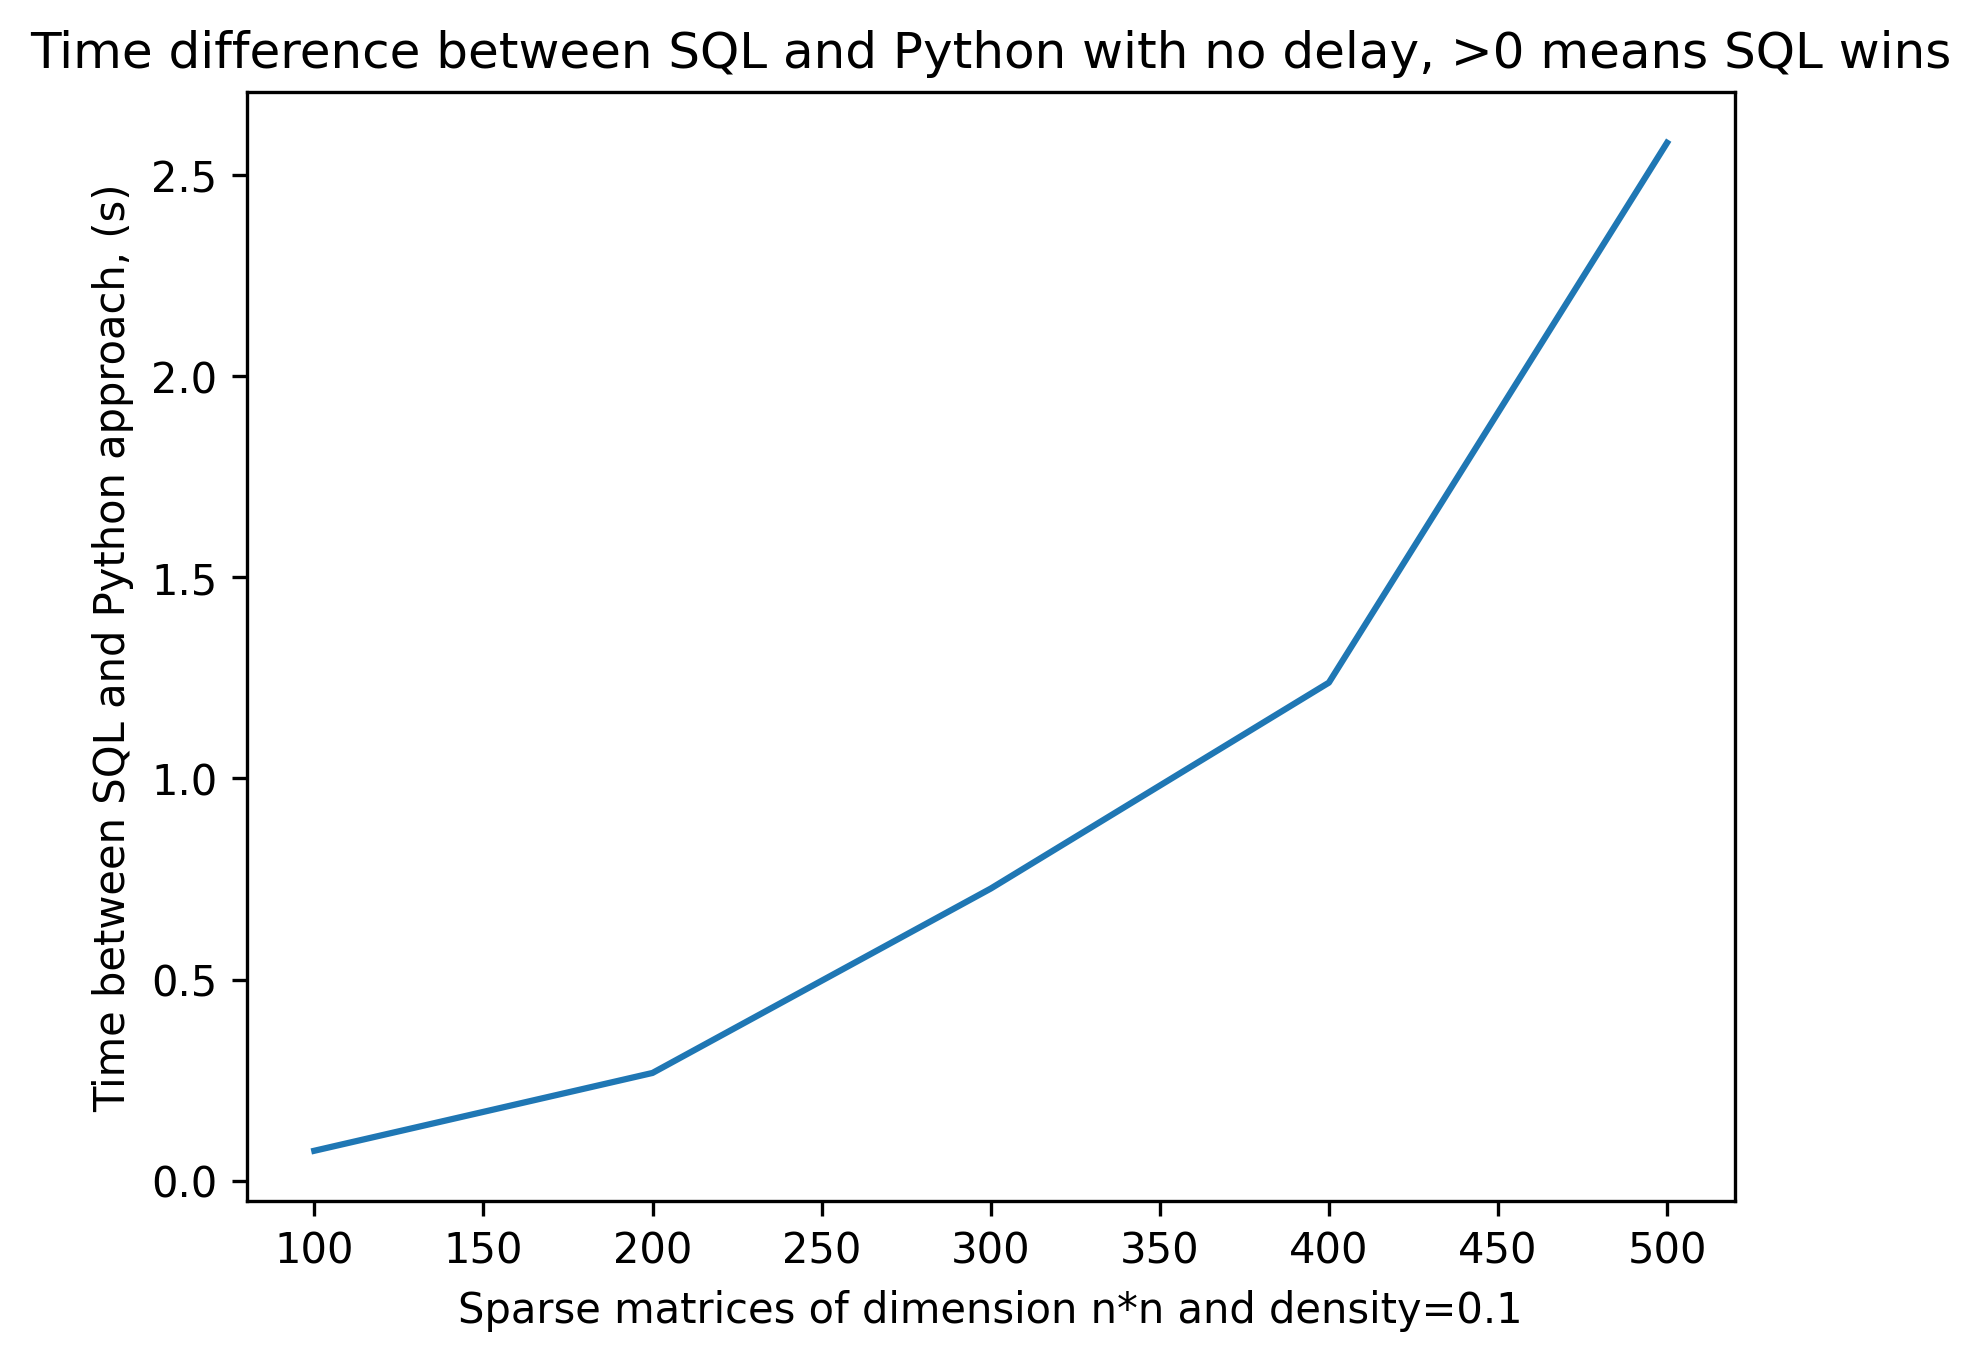

In [52]:
plt.plot(xs, ys)
plt.gcf().set_dpi(300)
plt.xlabel(F"Sparse matrices of dimension n*n and density={SPARSE_PROP}")
plt.ylabel("Time between SQL and Python approach, (s)")
if DELAY:
    plt.title("Time difference between SQL and Python with delay, >0 means SQL wins")
    plt.savefig(f"graphs/delay-{SPARSE_PROP}.png", bbox_inches="tight")
else:
    plt.title("Time difference between SQL and Python with no delay, >0 means SQL wins")
    plt.savefig(f"graphs/nodelay-{SPARSE_PROP}.png", bbox_inches="tight")
plt.show()